# Demo of L-DRL and DTP-DRL

A short demo of the L-DRL and DTP-DRL algorithms which we adapt to learn the backwards weights.

L-DRL by arXiv:2201.13415

DTP-DRL by arXiv:2006.14331

*Notation:*

$f(u) = W \sigma(u)$ maps potential $u$ onto potential in layer above

$g(u) = B \, \sigma(u)$ maps potential onto potential in layer below

$J_f$ is the forward Jacobian, i.e. $\frac{\partial u_{i+1}}{\partial u_{i}}$

$J_g$ is the backward Jacobian, i.e. $\frac{\partial u_i}{\partial u_{i+1}}$

In [1]:
import numpy as np
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec

In [2]:
def logistic(x):
    return 1/(1 + np.exp(-x))
def d_logistic(x):
    y = logistic(x)
    return y * (1.0 - y)

# cosine similarity between tensors
def cos_sim(A, B):
    return np.trace(A.T @ B) / np.linalg.norm(A) / np.linalg.norm(B)
def cos_sim_vectors(A, B):
    return A.T @ B / np.linalg.norm(A) / np.linalg.norm(B)

def f(u, W):
    return W @ logistic(u)
def df(u, W):
    return W @ np.diag(d_logistic(u))

def g(u, B):
    return B @ logistic(u)
def dg(u, B):
    return B @ np.diag(d_logistic(u))

def sigma(u):
    return logistic(u)

## L-DRL replicates backprop-Jacobians

In [3]:
seeds = 5
layers = [2, 3]

alpha = 1e-3
eta_B = 0.1

def update_B_LDRL(B, xi, r_diff):
    dB = eta_B * np.outer(xi, r_diff)
    dB -= eta_B * alpha * B
    
    return B + dB

In [4]:
np.random.seed(123)

W_seeds_time_series = []
B_seeds_time_series = []
u0_seeds_time_series = []

for j in range(seeds):
    
    u0 = np.random.normal(0,1,size=(layers[0]))
    W = np.random.normal(0,1,size=(layers[1],layers[0]))
    B = np.random.normal(0,1,size=(layers[0],layers[1]))
    
    W_time_series = [W]
    B_time_series = [B]
    u0_time_series = [u0]
    
    for i in range(50000):

        xi = np.random.normal(0,0.1,size=layers[0])
        # loss = (-xi.T @ (g(f(u0 + xi)) - g(f(u0))))

        r_diff = sigma(f(u0 + xi, W)) - sigma(f(u0, W))
        B = update_B_LDRL(B, xi, r_diff)
        B_time_series.append(B.copy())
        W_time_series.append(W.copy())
        u0_time_series.append(u0.copy())

    W_seeds_time_series.append(W_time_series)
    B_seeds_time_series.append(B_time_series)
    u0_seeds_time_series.append(u0_time_series)

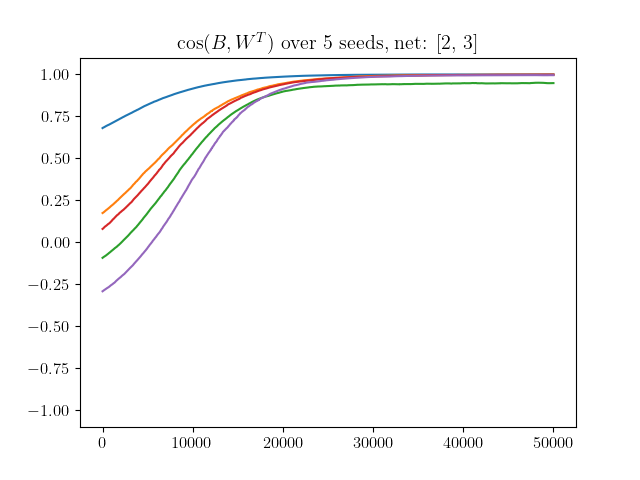

In [5]:
fig = plt.figure()

for i in range(len(B_seeds_time_series)):
    cos_B_WT_time_series = [cos_sim(B_seeds_time_series[i][j], W_seeds_time_series[i][j].T) for j in range(len(B_seeds_time_series[i]))]

    plt.plot(cos_B_WT_time_series)

title = "$\cos(B,W^T)$ over " + str(seeds) + " seeds, net: " + str(layers)
plt.title(title)
plt.ylim(-1.1,1.1)
plt.show()

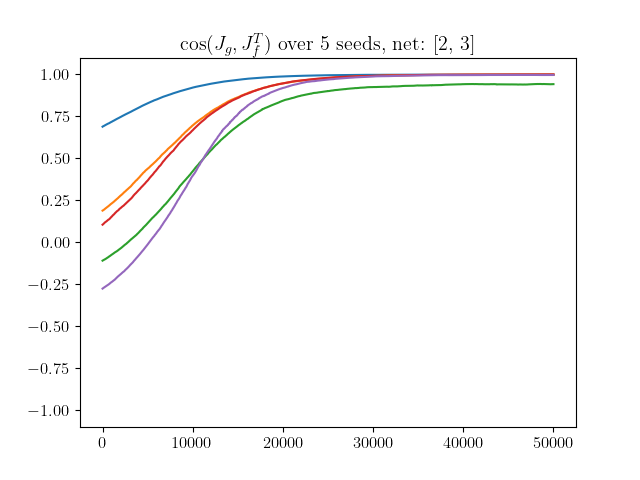

In [6]:
fig = plt.figure()

for i in range(len(B_seeds_time_series)):
    cos_Jacobian_time_series = [cos_sim(
        dg(f(u0_seeds_time_series[i][j], W_seeds_time_series[i][j]), B_seeds_time_series[i][j]),
        df(u0_seeds_time_series[i][j], W_seeds_time_series[i][j]).T
    ) for j in range(len(B_seeds_time_series[i]))]

    plt.plot(cos_Jacobian_time_series)
    
title = "$\cos(J_g,J_f^T)$ over " + str(seeds) + " seeds, net: " + str(layers)
plt.title(title)    
plt.ylim(-1.1,1.1)
plt.show()

## DTP-DRL reproduces GN-Jacobians

### Single layer inversion

In [7]:
seeds = 5
layers = [2, 3]

alpha = 1e-4
eta_B = 0.1

def update_B_DTPDRL(B, u_rec, r_diff):
    dB = - eta_B * np.outer(u_rec, r_diff)
    dB -= eta_B * alpha * B
    
    return B + dB

In [8]:
np.random.seed(123)

W_seeds_time_series = []
B_seeds_time_series = []
u0_seeds_time_series = []

for j in range(seeds):
    
    u0 = np.random.normal(0,1,size=(layers[0]))
    W = np.random.normal(0,1,size=(layers[1],layers[0]))
    B = np.random.normal(0,1,size=(layers[0],layers[1]))
    
    W_time_series = [W]
    B_time_series = [B]
    u0_time_series = [u0]
    
    for i in range(50000):

        xi = np.random.normal(0,0.1,size=layers[0])

        r_diff = sigma(f(u0 + xi, W)) - sigma(f(u0, W))
        u_rec = g(f(u0 + xi, W), B) - g(f(u0, W), B) - xi
        
        B = update_B_DTPDRL(B, u_rec, r_diff)
        B_time_series.append(B.copy())
        W_time_series.append(W.copy())
        u0_time_series.append(u0.copy())

    W_seeds_time_series.append(W_time_series)
    B_seeds_time_series.append(B_time_series)
    u0_seeds_time_series.append(u0_time_series)

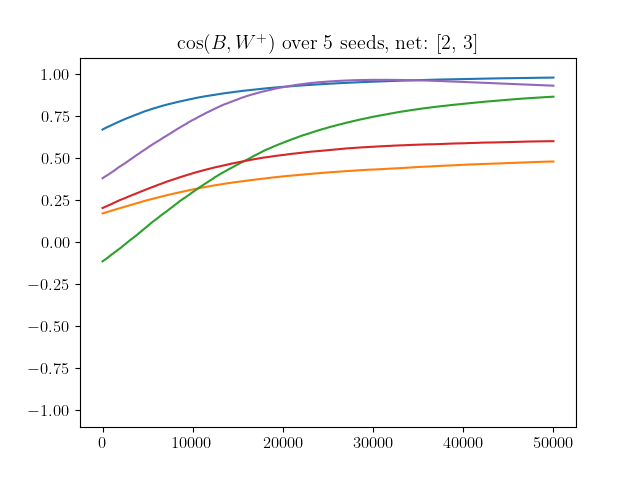

In [9]:
fig = plt.figure()

for i in range(len(B_seeds_time_series)):
    cos_B_WT_time_series = [cos_sim(B_seeds_time_series[i][j], np.linalg.pinv(W_seeds_time_series[i][j])) for j in range(len(B_seeds_time_series[i]))]

    plt.plot(cos_B_WT_time_series)

title = "$\cos(B,W^+)$ over " + str(seeds) + " seeds, net: " + str(layers)
plt.title(title)
plt.ylim(-1.1,1.1)
plt.show()

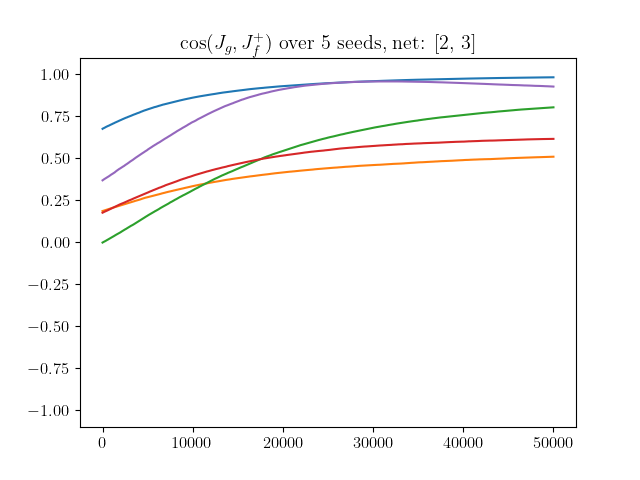

In [10]:
fig = plt.figure()

for i in range(len(B_seeds_time_series)):
    cos_Jacobian_time_series = [cos_sim(
        dg(f(u0_seeds_time_series[i][j], W_seeds_time_series[i][j]), B_seeds_time_series[i][j]),
        np.linalg.pinv(df(u0_seeds_time_series[i][j], W_seeds_time_series[i][j]))
    ) for j in range(len(B_seeds_time_series[i]))]

    plt.plot(cos_Jacobian_time_series)
    
title = "$\cos(J_g,J_f^+)$ over " + str(seeds) + " seeds, net: " + str(layers)
plt.title(title)    
plt.ylim(-1.1,1.1)
plt.show()